### Model Evaluation

In [1]:
import torch
from torch.utils.data import DataLoader
from backbones.resnet18_SE import CNN
import baseline_dataset as dataset
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d:\Miniconda\envs\CV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the validation dataset
def load_test_data(csv_file, image_dir, batch_size=64):
    val_dataset = dataset.StackDataset(csv_file=csv_file, image_dir=image_dir, img_size=224, stable_height='stable_height', train=False, singleTask=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return val_loader

In [3]:
# load the model
def load_model(model_path):
    model = CNN()
    checkpoint = torch.load(model_path, map_location=device)
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    model.to(device)
    model.eval()
    return model

### Evaluation Matrix

In [4]:
singleTask = False

In [5]:
# Macro-Average F1 Score
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Evaluate the model
def evaluate(model, val_loader, device):
    correct = 0
    total = 0
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    model.eval() 
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            if singleTask:
                labels = labels.to(device)
            else:
                labels = {k: v.to(device) for k, v in labels.items()}
            
            outputs = model(images)
            if singleTask:
                outputs = outputs
            else:
                outputs = outputs[0]
            _, predicted = torch.max(outputs, 1)
            
            if singleTask:
                true_labels = labels
            else:
                true_labels = labels["stable_height"]
            total += true_labels.size(0)
            
            correct += (predicted == true_labels).sum().item()

            tp += ((predicted == 1) & (true_labels == 1)).sum().item()
            fp += ((predicted == 1) & (true_labels == 0)).sum().item()
            fn += ((predicted == 0) & (true_labels == 1)).sum().item()

    accuracy = correct / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1 = f1_score(precision, recall)

    return accuracy, precision, recall, f1

In [6]:
csv_file = "data/train.csv"
image_dir = "data/train"
model_path = "models/exp7_resnet18_multiTask_baseline_67.32%_epoch27/model_epoch_27.pth"

In [7]:
# test model
def test_model(model_path, csv_file, image_dir):
    val_loader = load_test_data(csv_file, image_dir)
    model = load_model(model_path)
    model = model.to(device)
    accuracy, precision, recall, f1 = evaluate(model, val_loader, device)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

test_model(model_path, csv_file, image_dir)

Training data: 6912 samples
Validation data: 768 samples


C:\Users\Jinuo\AppData\Local\Temp\ipykernel_23332\3968337586.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Accuracy: 0.6731770833333334
Precision: 0.8979591836734694
Recall: 0.8354430379746836
F1 Score: 0.8655737704918033


### Result Visualization

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate F1 Score
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

# Evaluate function
def evaluate(model, val_loader, device, num_classes):
    correct = 0
    total = 0
    tp = np.zeros(num_classes)
    fp = np.zeros(num_classes)
    fn = np.zeros(num_classes)
    true_label_count = np.zeros(num_classes)
    pred_label_count = np.zeros(num_classes)

    model.eval()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = {k: v.to(device) for k, v in labels.items()}
            
            outputs = model(images)
            outputs = outputs[0]
            _, predicted = torch.max(outputs, 1)
            
            true_labels = labels["stable_height"].cpu()
            predicted = predicted.cpu()
            total += true_labels.size(0)
            
            correct += (predicted == true_labels).sum().item()

            # Count for each class
            for cls in range(num_classes):
                tp[cls] += ((predicted == cls) & (true_labels == cls)).sum().item()
                fp[cls] += ((predicted == cls) & (true_labels != cls)).sum().item()
                fn[cls] += ((predicted != cls) & (true_labels == cls)).sum().item()

                # Count the occurrences of each true and predicted label
                true_label_count[cls] += (true_labels == cls).sum().item()
                pred_label_count[cls] += (predicted == cls).sum().item()

    accuracy = correct / total if total > 0 else 0
    precision = tp / (tp + fp) if np.sum(tp + fp) > 0 else np.zeros(num_classes)
    recall = tp / (tp + fn) if np.sum(tp + fn) > 0 else np.zeros(num_classes)

    f1 = np.array([f1_score(precision[cls], recall[cls]) for cls in range(num_classes)])

    return accuracy, precision, recall, f1, true_label_count, pred_label_count

# Function to draw bar charts for true vs predicted labels
def draw_true_vs_pred(true_label_count, pred_label_count, num_classes):
    labels = np.arange(1, num_classes+1)
    
    plt.figure(figsize=(10, 6))
    
    bar_width = 0.35
    index = np.arange(num_classes) + 1
    
    # Plot true labels
    plt.bar(index, true_label_count, bar_width, label='True Labels', color='#D6E0C8')

    # Plot predicted labels
    plt.bar(index + bar_width, pred_label_count, bar_width, label='Predicted Labels', color='#4C6C43')

    plt.xlabel('Stable Height Class')
    plt.ylabel('Count')
    plt.title('True vs Predicted Labels for Each Class')
    plt.xticks(index + bar_width / 2, labels)
    plt.legend()

    plt.tight_layout()
    plt.show()

Training data: 6912 samples
Validation data: 768 samples


C:\Users\Jinuo\AppData\Local\Temp\ipykernel_22076\3968337586.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


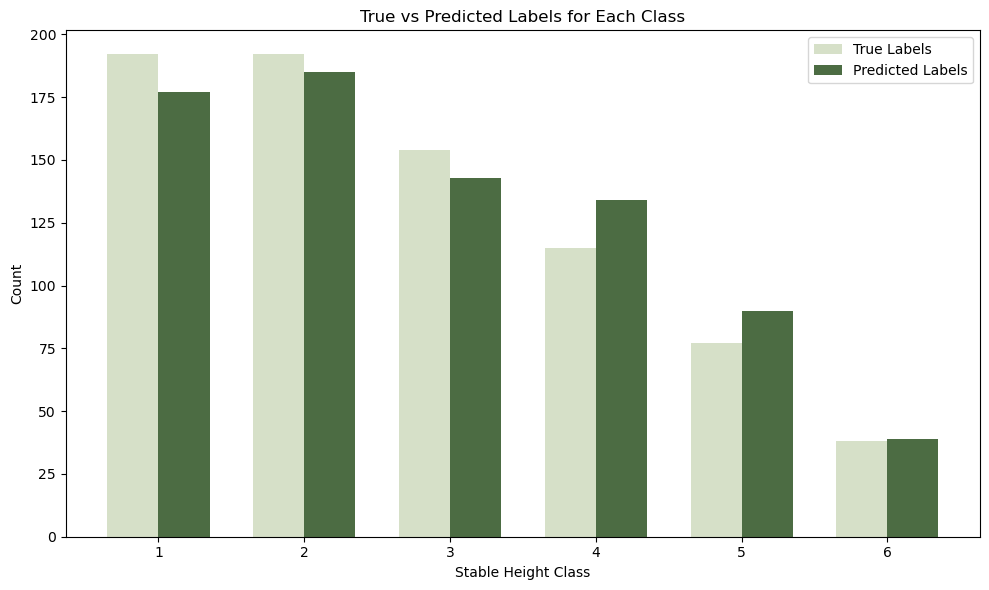

In [25]:
num_classes = 6
val_loader = load_test_data(csv_file, image_dir)
model = load_model(model_path)
model = model.to(device)
accuracy, precision, recall, f1, true_label_count, pred_label_count = evaluate(model, val_loader, device, num_classes)
draw_true_vs_pred(true_label_count, pred_label_count, num_classes)

### Grad-Cam Visualisation

In [4]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import numpy as np

In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        if isinstance(outputs, tuple):
            return outputs[0]
        else:
            return outputs

def grad_cam_visualize(model, val_loader, device='cpu'):
    wrapped_model = ModelWrapper(model)
    
    wrapped_model.to(device)
    
    wrapped_model.eval()
    
    # target_layer = wrapped_model.model.base_model.features[21].branch3[1].conv
    # target_layer = wrapped_model.model.self_attention.query_conv
    target_layer = wrapped_model.model.self_attention.value_conv
    # target_layer = wrapped_model.model.self_attention.key_conv

    cam = GradCAM(model=wrapped_model, target_layers=[target_layer])

    images_list = []
    cam_images_list = []
    titles_list = []
    num_images = 0
    max_images = 16 

    for idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)

        outputs = wrapped_model(images)

        grayscale_cam = cam(input_tensor=images, targets=None)

        batch_size = images.size(0)
        for i in range(batch_size):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img - img.min()) / (img.max() - img.min())

            cam_image = show_cam_on_image(img, grayscale_cam[i], use_rgb=True)

            true_label = labels["stable_height"][i].item() + 1
            predicted_label = outputs[i].argmax().item() + 1

            title = f"True: {true_label}, Pred: {predicted_label}"

            cam_images_list.append(cam_image)
            titles_list.append(title)

            num_images += 1
            if num_images >= max_images:
                break
        if num_images >= max_images:
            break

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(cam_images_list[idx])
        ax.set_title(titles_list[idx], fontsize=14)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


False prediction

In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        if isinstance(outputs, tuple):
            return outputs[0]
        else:
            return outputs

def grad_cam_visualize(model, val_loader, device='cpu'):
    wrapped_model = ModelWrapper(model)
    
    wrapped_model.to(device)
    
    wrapped_model.eval()

    # target_layer = wrapped_model.model.self_attention.value_conv
    target_layer = wrapped_model.model.self_attention.key_conv
    # target_layer = wrapped_model.model.self_attention.query_conv

    cam = GradCAM(model=wrapped_model, target_layers=[target_layer])

    cam_images_list = []
    titles_list = []
    num_images = 0
    max_images = 16 

    for idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)

        outputs = wrapped_model(images)

        grayscale_cam = cam(input_tensor=images, targets=None)

        batch_size = images.size(0)
        for i in range(batch_size):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img - img.min()) / (img.max() - img.min())

            cam_image = show_cam_on_image(img, grayscale_cam[i], use_rgb=True)

            true_label = labels["stable_height"][i].item() + 1
            predicted_label = outputs[i].argmax().item() + 1

            # only keep false prediction
            if true_label != predicted_label:
                title = f"True: {true_label}, Pred: {predicted_label} (Incorrect)"
                cam_images_list.append(cam_image)
                titles_list.append(title)

                num_images += 1
                if num_images >= max_images:
                    break
        if num_images >= max_images:
            break

    if len(cam_images_list) > 0:
        fig, axes = plt.subplots(4, 4, figsize=(15, 15))
        for idx, ax in enumerate(axes.flatten()):
            if idx < len(cam_images_list):
                ax.imshow(cam_images_list[idx])
                ax.set_title(titles_list[idx], fontsize=14)
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

In [8]:
csv_file = "data/train.csv"
image_dir = "data/train"
model_path = "models/exp28_10_fold_90_10_corrected/best_model_fold_5.pth"

val_loader = load_test_data(csv_file, image_dir)
model = load_model(model_path)

def list_model_layers(model):
    for name, module in model.named_modules():
        print(name, ":", module)

list_model_layers(model)

Training data: 6912 samples
Validation data: 768 samples


C:\Users\Jinuo\AppData\Local\Temp\ipykernel_19048\3968337586.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


 : CNN(
  (base_model): InceptionV4(
    (features): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (1): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (2): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (3): Mixed3a(
        (maxpool): MaxPo

In [50]:
def get_final_conv_layer(model):
    final_conv = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            final_conv = (name, module)
    return final_conv

final_layer_name, _ = get_final_conv_layer(model)
print(f"final conv：{final_layer_name}")

final conv：self_attention.value_conv


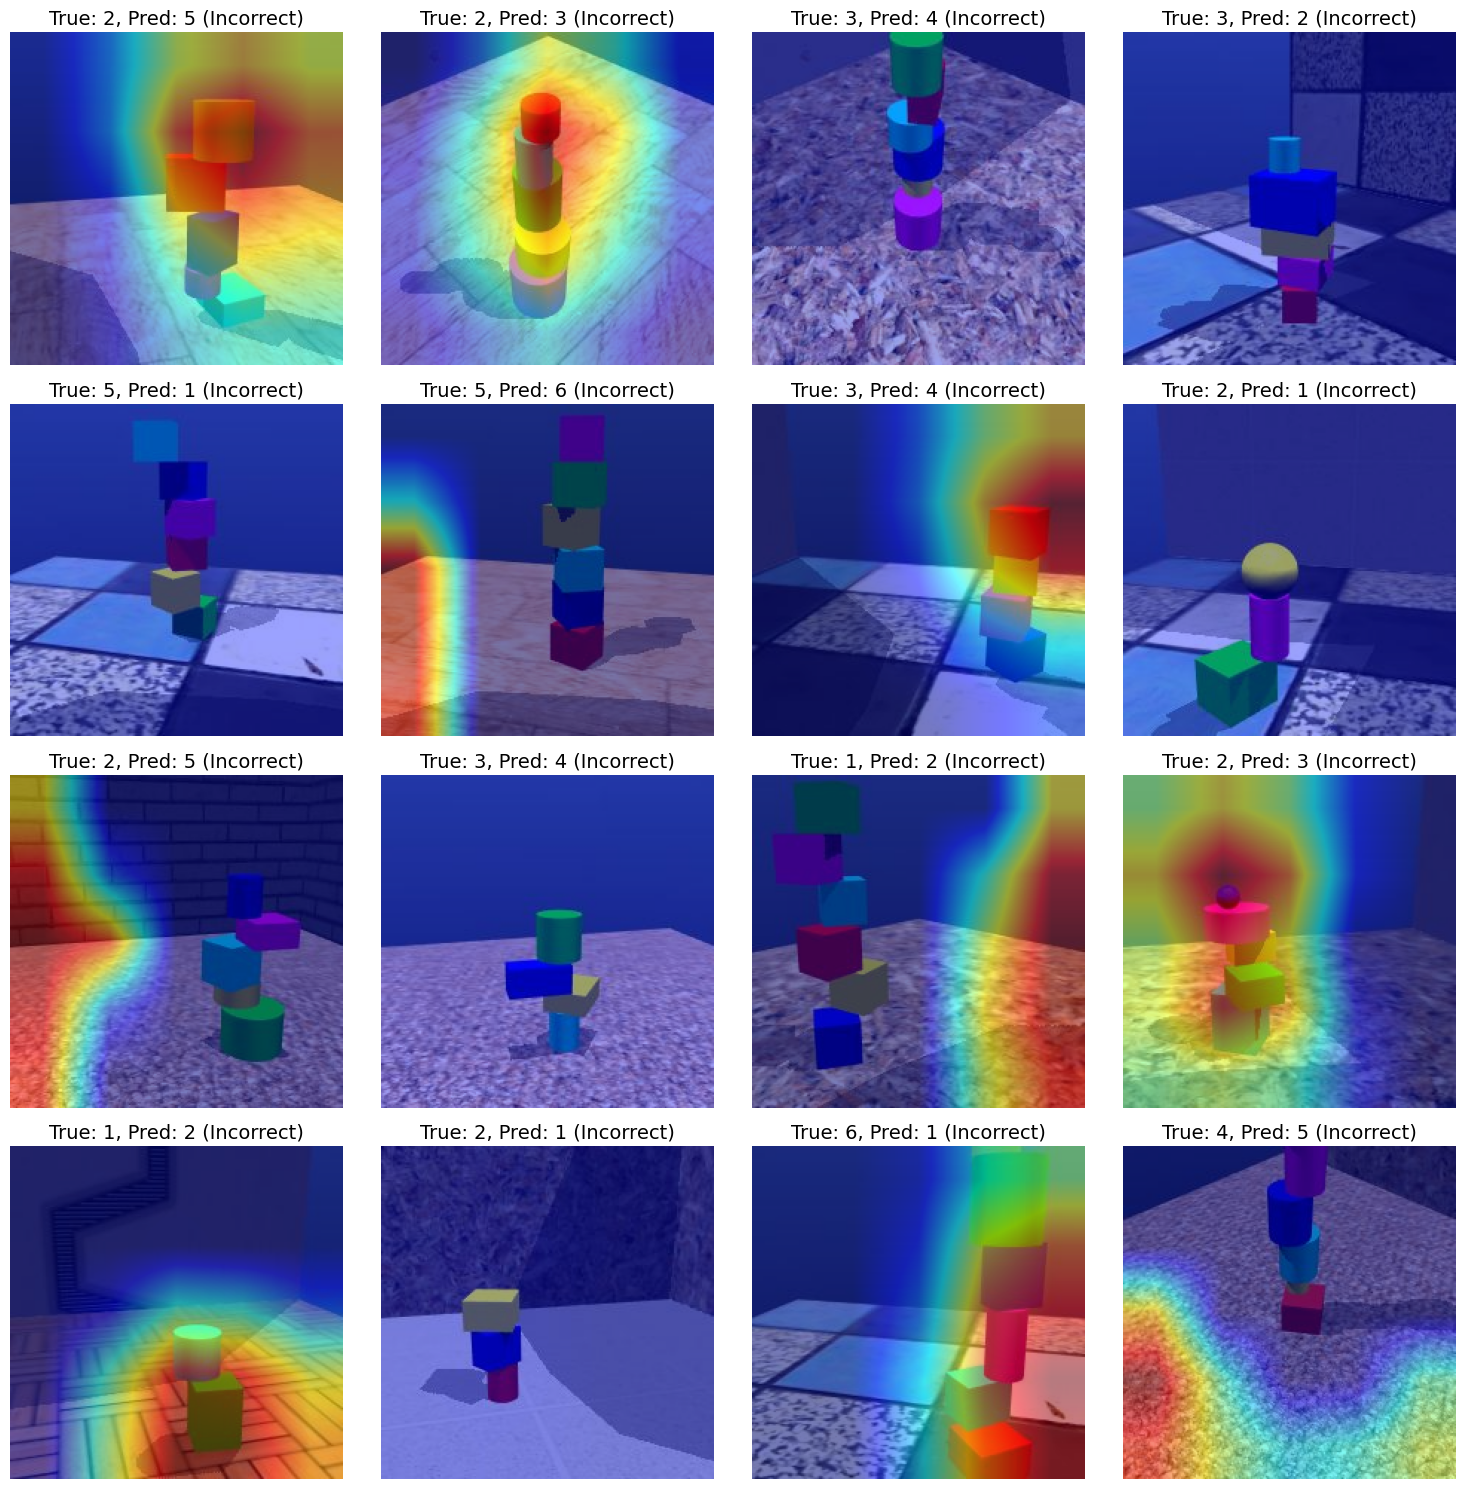

In [49]:
grad_cam_visualize(model, val_loader, device=device) 